#Time Series Forecasting

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#NVIDIA STOCKS

In [3]:
data = yf.download('NVDA', period='5y', interval='1d')

/tmp/ipython-input-3299539959.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('NVDA', period='5y', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-08-12,11.402665,11.429327,10.922248,10.954642,464412000
2020-08-13,11.405407,11.683242,11.318444,11.508068,374460000
2020-08-14,11.526011,11.666298,11.402916,11.492122,366436000
2020-08-17,12.296471,12.368982,11.778428,11.812316,621300000
2020-08-18,12.220469,12.454946,12.046542,12.409097,503448000


In [5]:
data.columns

MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])

In [6]:
df = data[[('Close', 'NVDA')]].copy()
df.columns = ['Close']
df.reset_index(inplace=True)

##We only need Close column

In [7]:
df.head()

,Date,Close
0,2020-08-12,11.402665
1,2020-08-13,11.405407
2,2020-08-14,11.526011
3,2020-08-17,12.296471
4,2020-08-18,12.220469


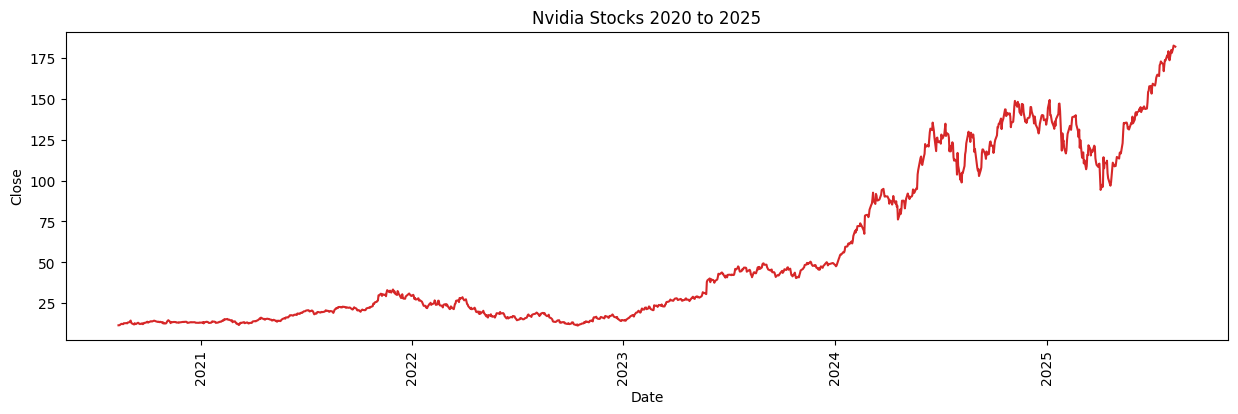

In [8]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Close', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    # ax.set_xticks(ax.get_xticks()[::2])
    plt.xticks(rotation=90)
    plt.show()


plot_df(df, x=df['Date'], y=df['Close'], title='Nvidia Stocks 2020 to 2025')

#Decompostion

##Multiplicative Decomposition

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)

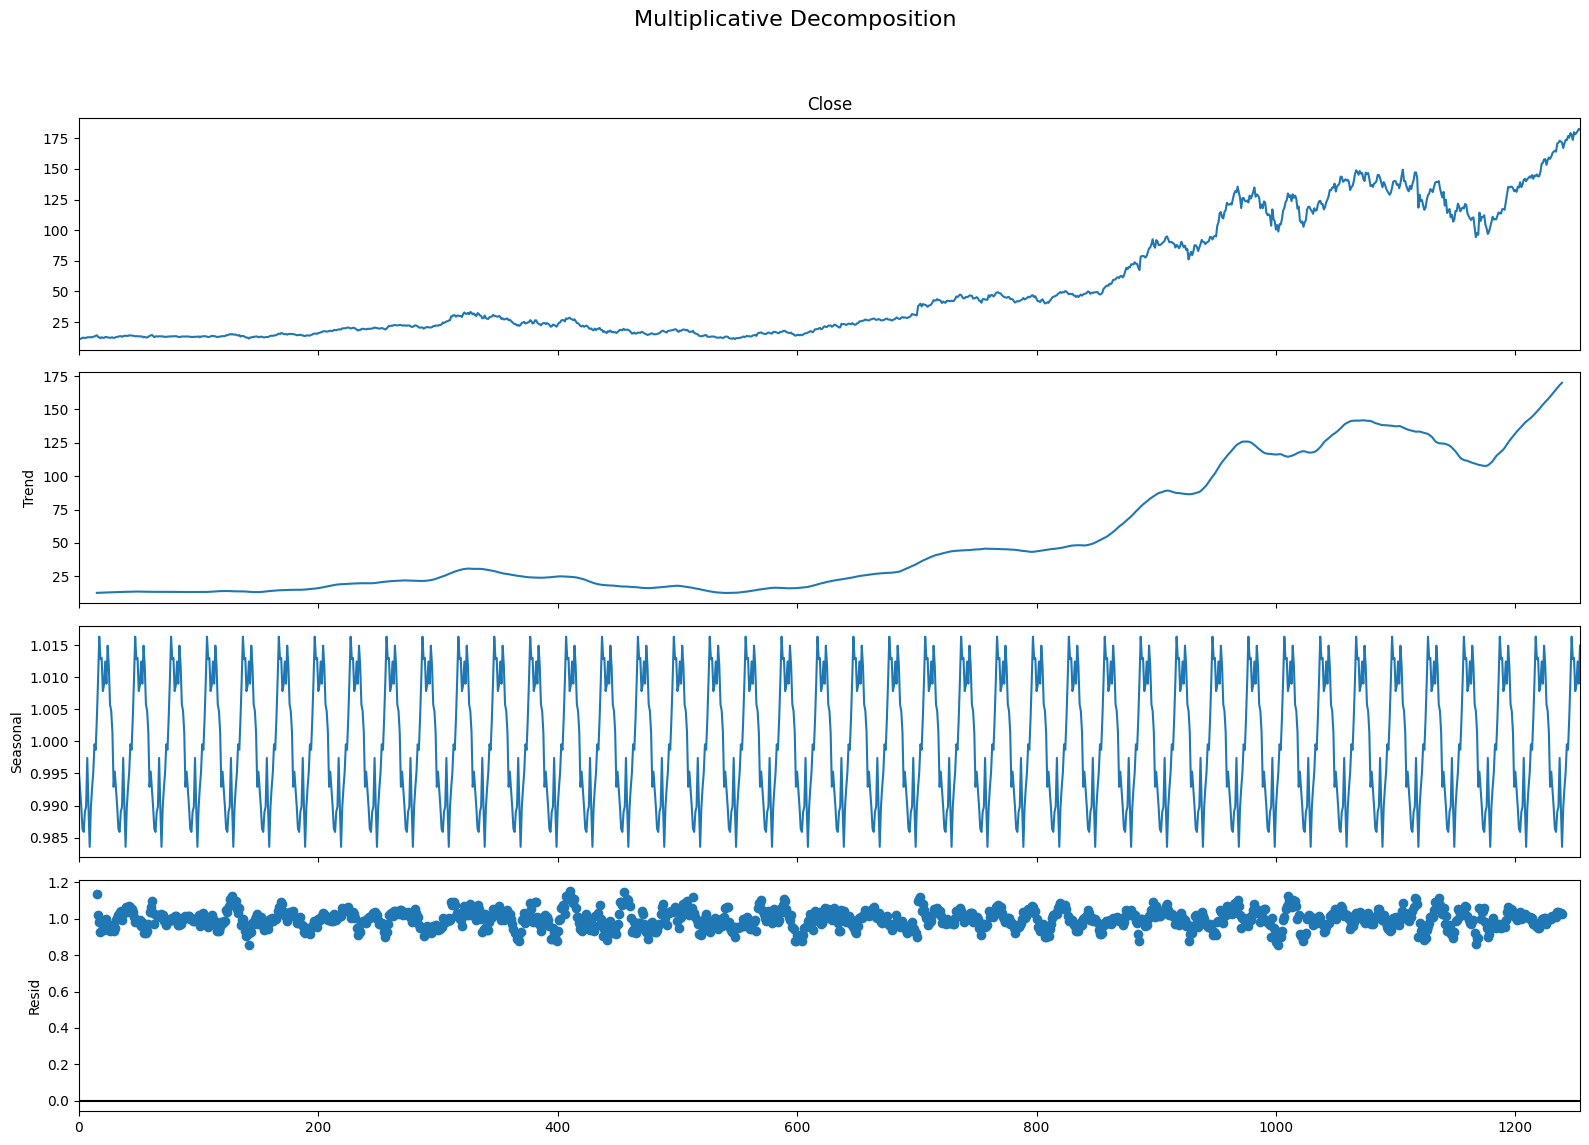

In [10]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


##Residuals seems preety random which good !

Additive Decompostion

In [11]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Close'], model='additive', period=30)

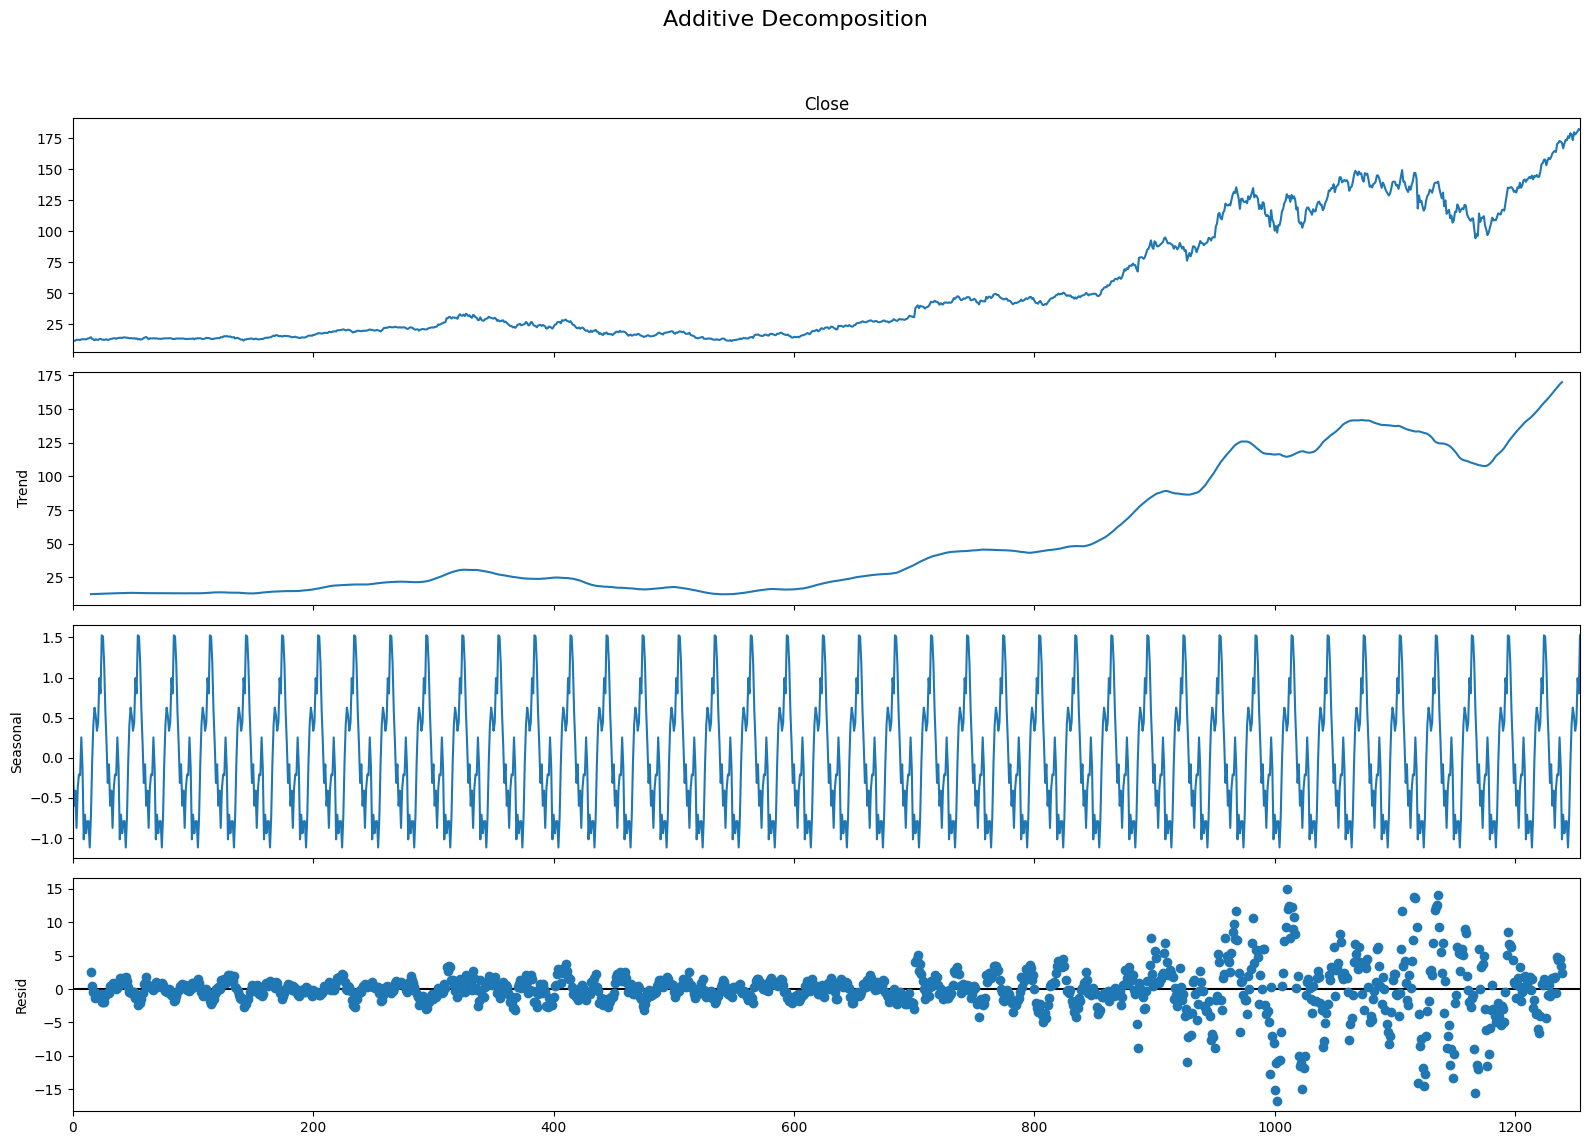

In [12]:
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

##We can see residuals are capturing some pattern that's why we consider Multiplicative decompostion over additive ! (800-1200)

## Now let's check if this data is stationary or not !

###Augmented Dickey-Fuller (ADF) Test

In [13]:
 #Augmented Dickey-Fuller (ADF) Test
 from statsmodels.tsa.stattools import adfuller

# Assume 'df' has 'Date' and 'Close' columns
ts = df['Close']

adf_result = adfuller(ts)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: 1.2209997937478576
p-value: 0.9961278084775181
Critical Values: {'1%': -3.435660336370594, '5%': -2.863885022214541, '10%': -2.568018522153254}


###KPSS test (Kwiatkowski-Phillips-Schmidt-Shin test)

In [14]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(ts, regression='c', nlags="auto")

print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

KPSS Statistic: 4.965982242328113
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/tmp/ipython-input-3140725119.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags="auto")


###Phillips-Perron Test (Z-tau)   

In [15]:
pip install arch

In [16]:
from arch.unitroot import PhillipsPerron

pp_test = PhillipsPerron(ts)

print(pp_test.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.398
P-value                         0.997
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## The Result of all three test suggest that out series is not stationary

Let's Try differencing and then check again

In [17]:
df['Close_diff'] = df['Close'].diff()

In [18]:
df = df.dropna()

In [19]:
df.head()

,Date,Close,Close_diff
1,2020-08-13,11.405407,0.002742
2,2020-08-14,11.526011,0.120604
3,2020-08-17,12.296471,0.770460
4,2020-08-18,12.220469,-0.076002
5,2020-08-19,12.098619,-0.121849


In [20]:
df = df.set_index('Date')
ts = df['Close_diff']

In [21]:
ts

,Close_diff
Date,
2020-08-13,0.002742
2020-08-14,0.120604
2020-08-17,0.770460
2020-08-18,-0.076002
2020-08-19,-0.121849
...,...
2025-08-05,-1.740005
2025-08-06,1.160004
2025-08-07,1.350006


### Let's Perform Stationary tests

Augmented Dickey-Fuller (ADF) Test

In [22]:
# Assume 'df' has 'Date' and 'Close' columns
adf_result = adfuller(ts)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -6.3817186540656055
p-value: 2.2139386795282518e-08
Critical Values: {'1%': -3.4356689751083374, '5%': -2.8638888336592387, '10%': -2.5680205519744055}


KPSS test (Kwiatkowski-Phillips-Schmidt-Shin test)

In [23]:
kpss_result = kpss(ts, regression='c', nlags="auto")

print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

KPSS Statistic: 0.4447803722807779
p-value: 0.05785328781000954
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Phillips-Perron Test (Z-tau)   

In [24]:
pp_test = PhillipsPerron(ts)

print(pp_test.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -39.069
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Key Takeaways from Each Test 📈
ADF Test: The p-value (<0.05) and the test statistic (more negative than the critical values) led to the rejection of the null hypothesis of a unit root, indicating stationarity.

KPSS Test: The p-value (>0.05) and the test statistic (less than the critical value) led to a failure to reject the null hypothesis of stationarity, further supporting the conclusion.

Phillips-Perron Test: The p-value (<0.05) and the test statistic (more negative than the critical values) led to the rejection of the null hypothesis of a unit root, also confirming stationarity.

All three tests consistently point to the same conclusion, giving a high degree of confidence that the time series is stationary. This is a desirable property for many time series models, such as ARIMA, as it means the statistical properties of the series (like mean and variance) remain constant over time.

##Let's Detrend The Data

In [25]:
df.columns

Index(['Close', 'Close_diff'], dtype='object')

In [26]:
df=df.drop(columns='Close_diff')

 ## Subtract the line of best fit

Text(0.5, 1.0, 'Closing detrended by subtracting the least squares fit')

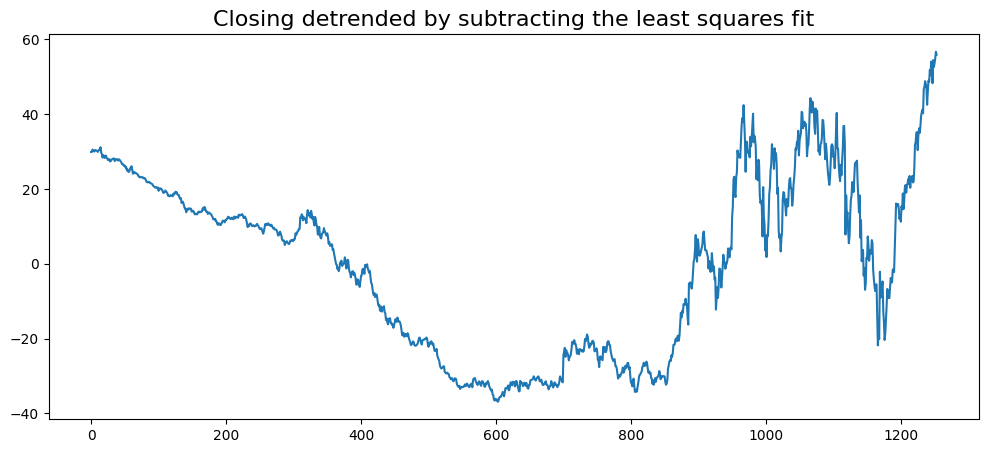

In [27]:
# Using scipy: Subtract the line of best fit
plt.figure(figsize=(12,5))
from scipy import signal
detrended = signal.detrend(df['Close'].values)
plt.plot(detrended)
plt.title('Closing detrended by subtracting the least squares fit', fontsize=16)

##Subtracting the Trend Component

Text(0.5, 1.0, 'Closing detrended by subtracting the trend component')

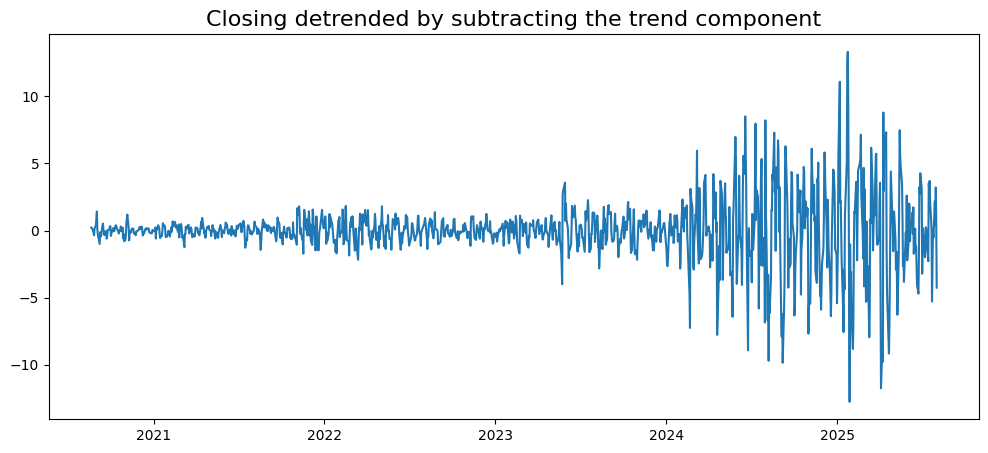

In [28]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['Close'], model='multiplicative', period=12)
detrended = df['Close'].values - result_mul.trend
plt.figure(figsize=(12,5), dpi=100)
plt.plot(detrended)
plt.title('Closing detrended by subtracting the trend component', fontsize=16)

##Deseasonalize

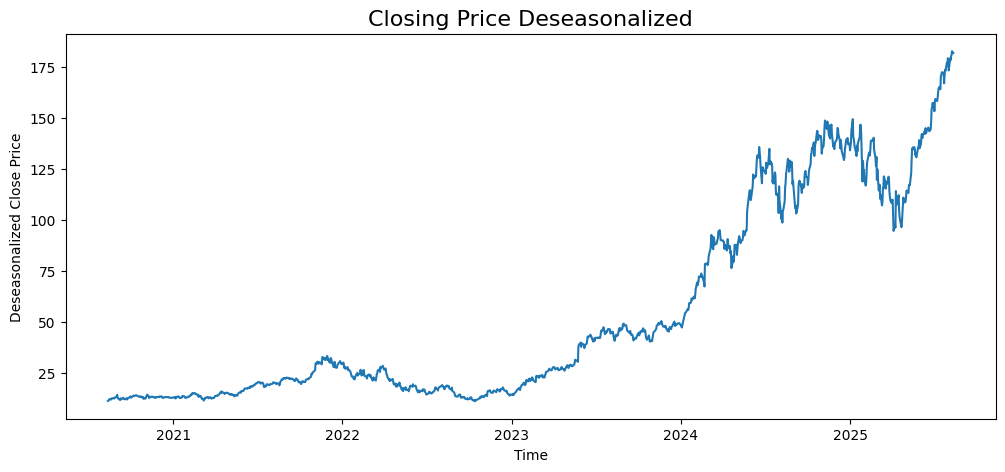

In [29]:
# Time Series Decomposition
result_mul = seasonal_decompose(df['Close'], model='multiplicative', period=12)

# Deseasonalize
deseasonalized = df['Close'].values / result_mul.seasonal

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(deseasonalized)
plt.title('Closing Price Deseasonalized', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Deseasonalized Close Price')
plt.show()

###After Deseasonalising the data there doesn't seem to have much difference suggesting that there mught not be seasonality in our data

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

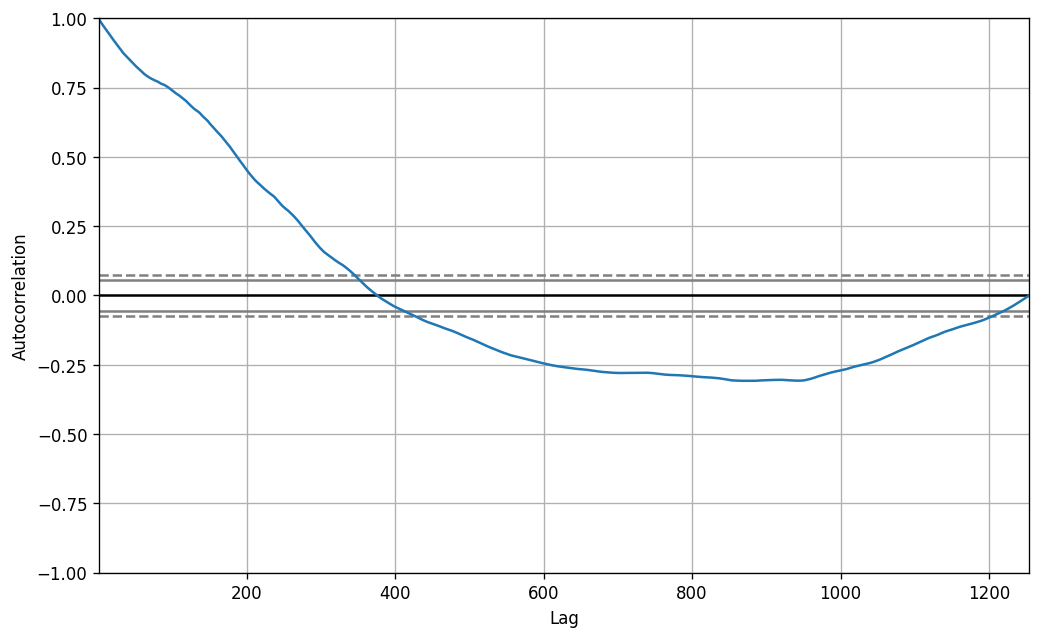

In [30]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['Close'].tolist())

## No Seasonality , No Stationary , Strong Trend

Let's see Autocorrelation & Partial Autocorrelation

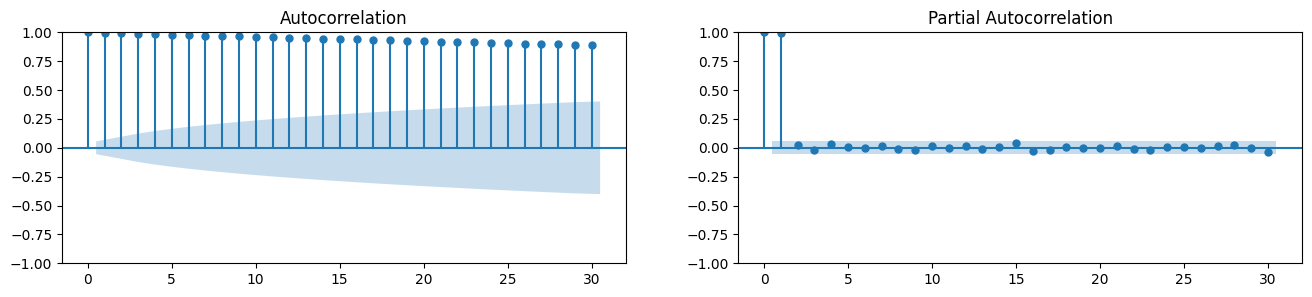

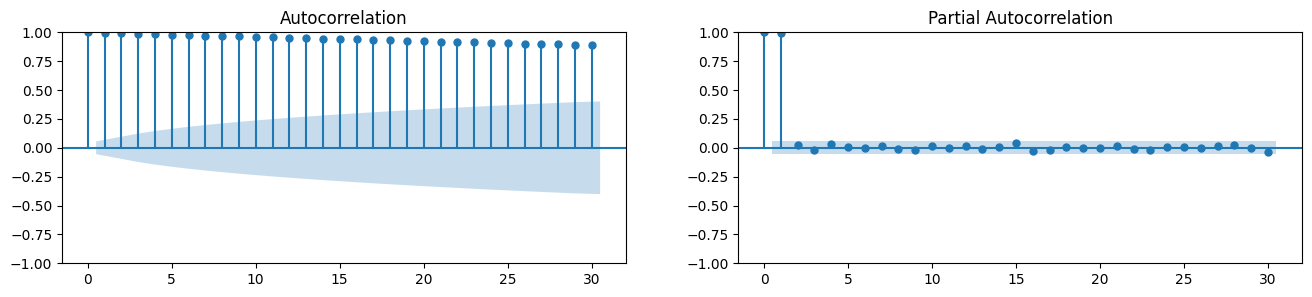

In [31]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Close'].tolist(), lags=30, ax=axes[0])
plot_pacf(df['Close'].tolist(), lags=30, ax=axes[1])

Autocorrelation: most values are statistically significant

Partial Autocorrelation : Almost all the values are under confidence intervel meaning they are statistically insignficant  

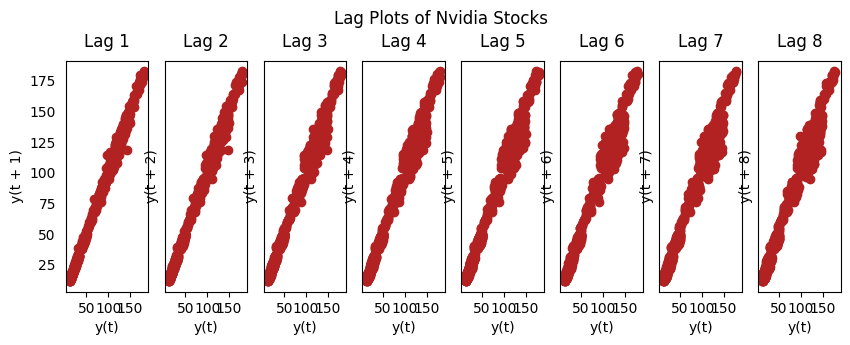

In [32]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 8, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:8]):
    lag_plot(df['Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Nvidia Stocks', y=1.05)
plt.show()

Gradual decay in correlation over lags

## Moving Average

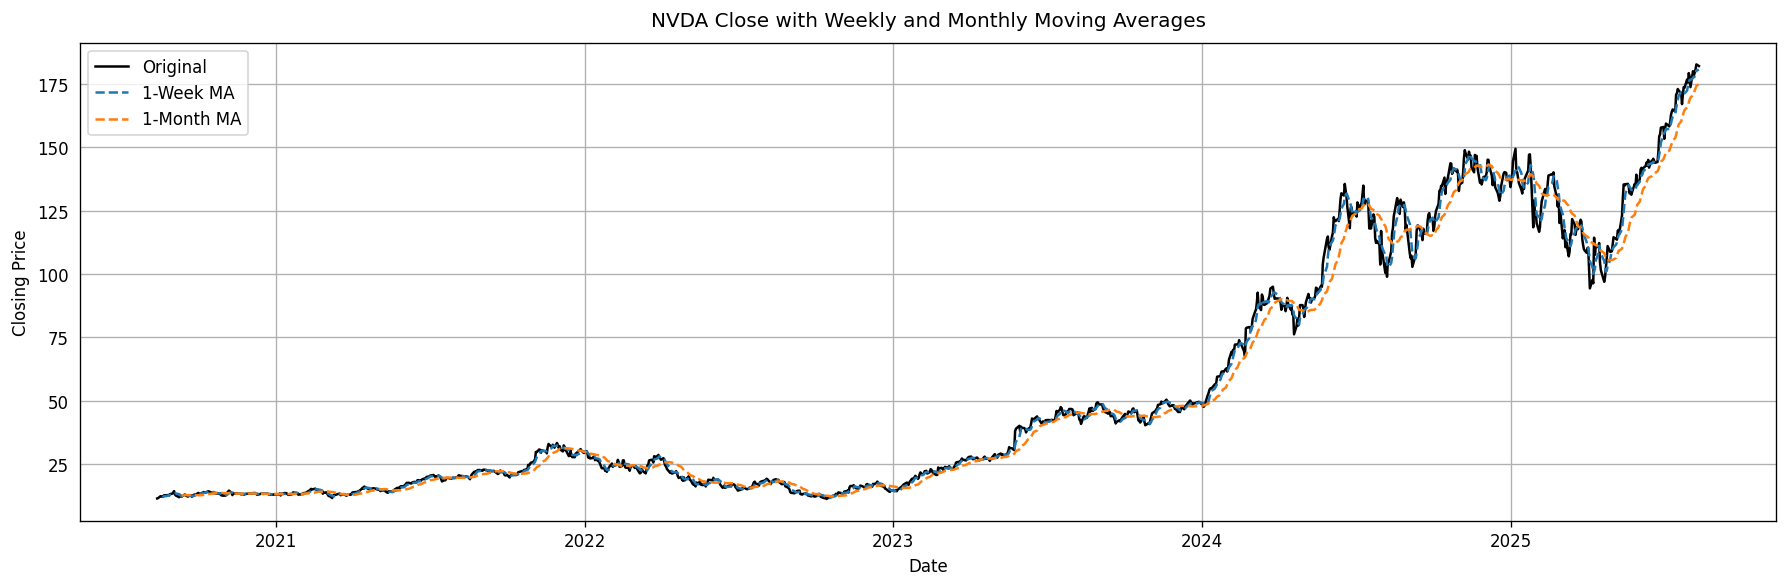

In [33]:
df['MA_1W'] = df['Close'].rolling(window=5).mean()
df['MA_1M'] = df['Close'].rolling(window=21).mean()

plt.figure(figsize=(15,5))
plt.plot(df['Close'], label='Original', color='black')
plt.plot(df['MA_1W'], label='1-Week MA', linestyle='--')
plt.plot(df['MA_1M'], label='1-Month MA', linestyle='--')

plt.title('NVDA Close with Weekly and Monthly Moving Averages')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Zoomed in view(last 6 months) for better visual analysis

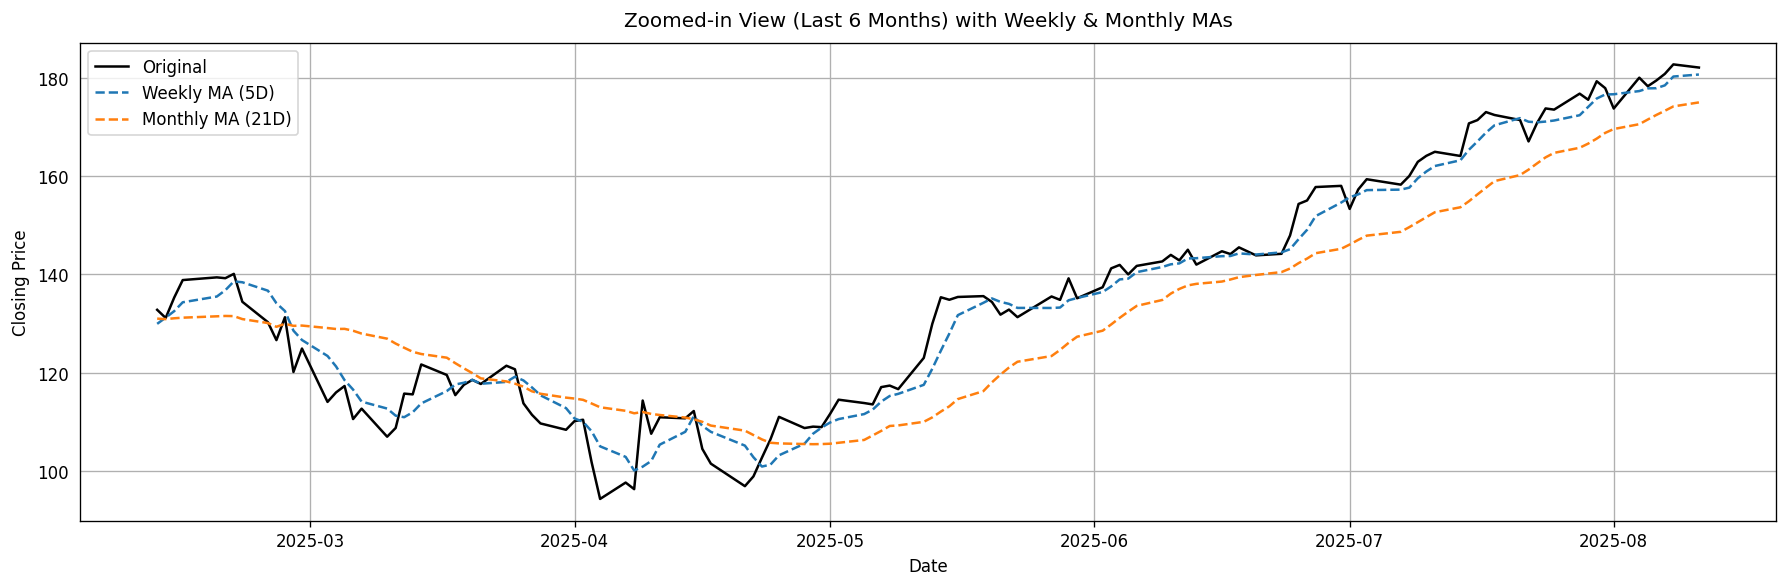

In [34]:
# Weekly and Monthly Moving Averages (assuming daily data)
df['MA_weekly'] = df['Close'].rolling(window=5).mean()    # approx. 5 trading days in a week
df['MA_monthly'] = df['Close'].rolling(window=21).mean()  # approx. 21 trading days in a month


end_date = df.index.max()
start_date = end_date - pd.DateOffset(months=6)
zoom_df = df.loc[start_date:end_date]

# Plot
plt.figure(figsize=(15,5))
plt.plot(zoom_df['Close'], label='Original', color='black')
plt.plot(zoom_df['MA_weekly'], label='Weekly MA (5D)', linestyle='--')
plt.plot(zoom_df['MA_monthly'], label='Monthly MA (21D)', linestyle='--')

plt.title('Zoomed-in View (Last 6 Months) with Weekly & Monthly MAs')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The analysis confirms that differencing made the time series stationary, and there doesn't appear to be significant seasonality.

Let's See how Differencing affects the data

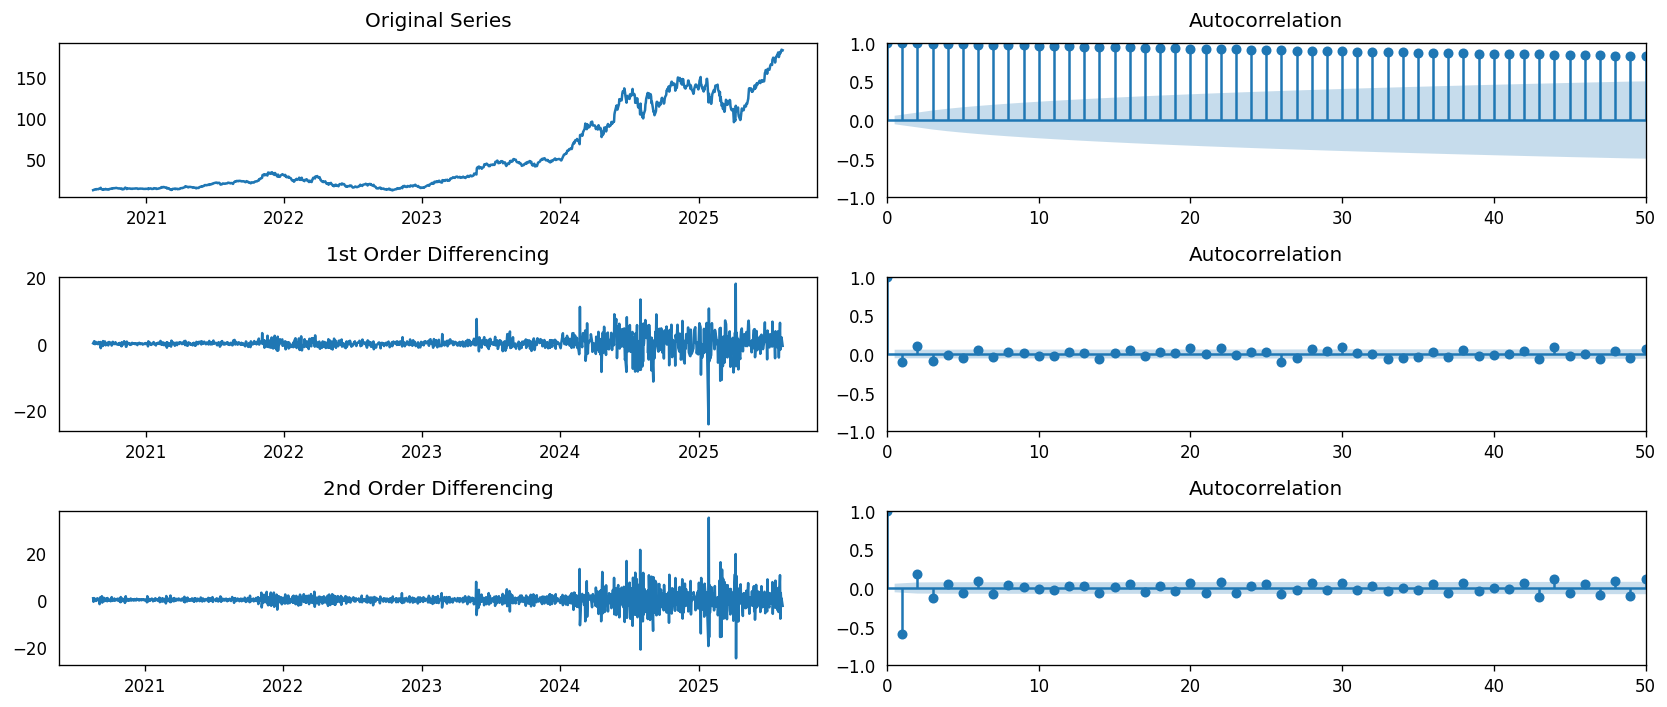

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (14, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot original series
axes[0, 0].plot(df['Close'])
axes[0, 0].set_title('Original Series')
plot_acf(df['Close'], ax=axes[0, 1], lags=50)
axes[0, 1].set_xlim([0, 50])  # Limit ACF x-axis to 50 lags

# First differencing
axes[1, 0].plot(df['Close'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Close'].diff().dropna(), ax=axes[1, 1], lags=50)
axes[1, 1].set_xlim([0, 50])

# Second differencing
axes[2, 0].plot(df['Close'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Close'].diff().diff().dropna(), ax=axes[2, 1], lags=50)
axes[2, 1].set_xlim([0, 50])

plt.tight_layout()
plt.show()

First-Order Differencing ✅

The middle row shows the results after applying first-order differencing. The time series plot on the left now fluctuates around a constant mean (zero), indicating the trend has been successfully removed. More importantly, the corresponding ACF plot on the right shows that all autocorrelation values (except for lag 0) are now within the confidence intervals (the blue shaded region). This sharp drop-off to zero autocorrelation confirms that the series has become stationary.

# Forecasting

Let's Fit Auto ARIMA

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")

In [37]:
df.head()

,Close,MA_1W,MA_1M,MA_weekly,MA_monthly
Date,,,,,
2020-08-13,11.405407,NaN,NaN,NaN,NaN
2020-08-14,11.526011,NaN,NaN,NaN,NaN
2020-08-17,12.296471,NaN,NaN,NaN,NaN
2020-08-18,12.220469,NaN,NaN,NaN,NaN
2020-08-19,12.098619,11.909395,NaN,11.909395,NaN


In [38]:
df.drop(columns=['MA_1W','MA_1M','MA_weekly'	,'MA_monthly'],inplace=True)

In [39]:
df.head()

,Close
Date,
2020-08-13,11.405407
2020-08-14,11.526011
2020-08-17,12.296471
2020-08-18,12.220469
2020-08-19,12.098619


In [40]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
#get_ipython().system('pip uninstall pmdarima numpy -y')
#get_ipython().system('pip install numpy==1.26.0') # Specify a version known to work
#get_ipython().system('pip install pmdarima')

In [42]:
import pmdarima as pm
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [43]:
train_size = int(len(df)* 0.8)
train , test = df.iloc[:train_size],df.iloc[train_size:]

In [44]:
arima_model = pm.auto_arima(train,seasonal = False,
                            stepwise = True, suppress_warnings = True,
                            trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.47 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4514.714, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4143.233, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4512.721, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4035.992, Time=0.68 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3894.758, Time=0.93 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3880.281, Time=1.38 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3785.878, Time=1.51 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=3670.315, Time=1.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=3669.140, Time=1.82 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(5,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 s

In [46]:
from pmdarima.arima import auto_arima

# Refit the model if not already saved
model = auto_arima(df['Close'], seasonal=False, stepwise=True, trace=True)

# Fit to the data
model_fit = model.fit(df['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5629.817, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5651.097, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5640.832, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5642.768, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5653.469, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5627.831, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5633.623, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5626.791, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5627.819, Time=0.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5631.069, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5629.788, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.558 seconds


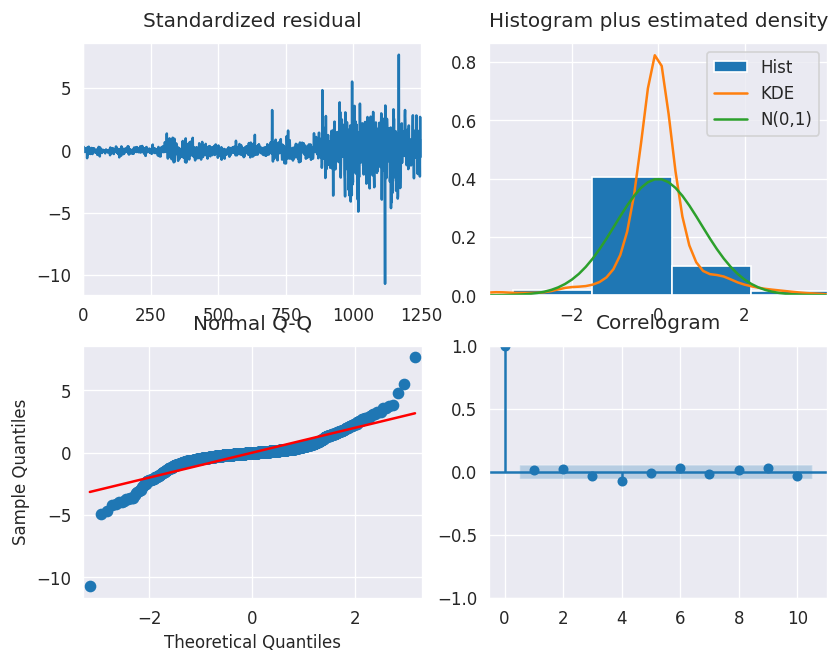

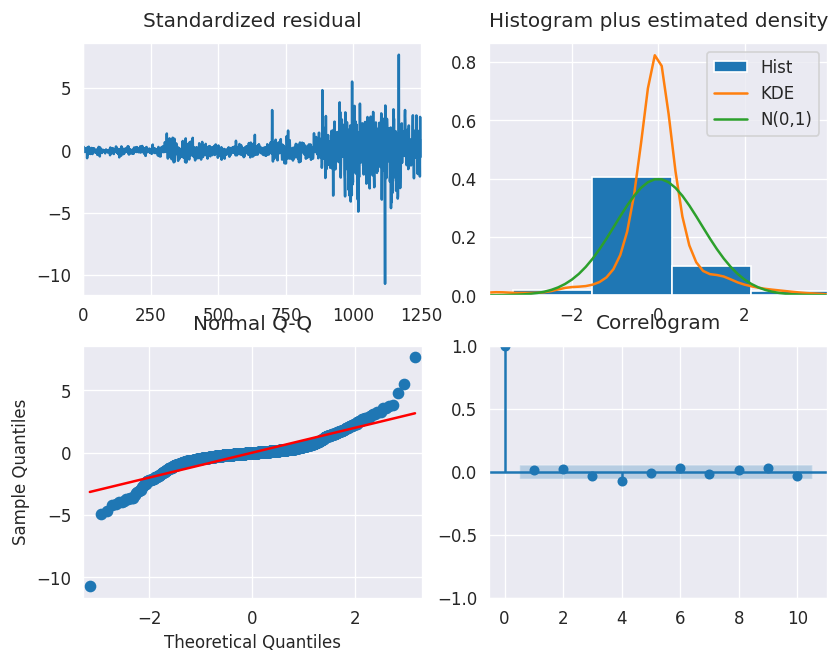

In [63]:
model.summary()
model.plot_diagnostics(figsize=(8, 6))

In [64]:
n_steps = 30  # change as needed
forecast, conf_int = model.predict(n_periods=n_steps, return_conf_int=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [68]:
n_steps = len(test)  # Make sure forecast matches test size
forecast, conf_int = model.predict(n_periods=n_steps, return_conf_int=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


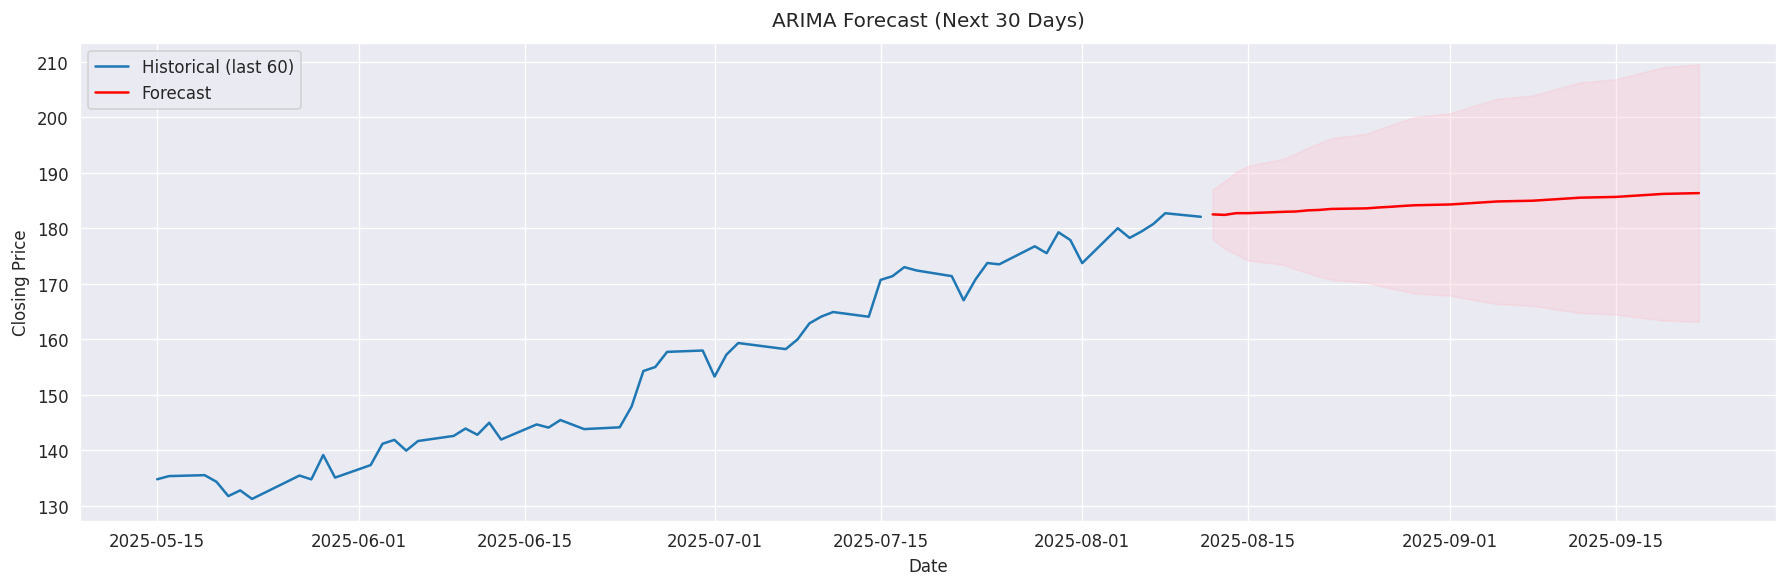

In [66]:
import matplotlib.pyplot as plt

# Forecast next 30 steps
n_periods = 30
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Create index for forecast
forecast_index = pd.date_range(df.index[-1], periods=n_periods+1, freq='B')[1:]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df[-60:], label='Historical (last 60)')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 66.21707468618601, RMSE: 68.45823439640517


I noticed the MAE and RMSE values are quite high, which suggests that the current ARIMA model might not be capturing the patterns in the data very well.

# Let's change this problem to Supervised Learning

In [71]:
def create_supervised_data(series, n_lags=3):
    """
    Create a supervised learning dataset from a univariate time series.

    Parameters:
        series (pd.Series): Original time series
        n_lags (int): Number of lag observations to use as features

    Returns:
        pd.DataFrame: Supervised learning dataframe
    """
    df = pd.DataFrame(series)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

# Apply the transformation
supervised_df = create_supervised_data(df['Close'], n_lags=3)
supervised_df.head()

,Close,lag_1,lag_2,lag_3
Date,,,,
2020-08-18,12.220469,12.296471,11.526011,11.405407
2020-08-19,12.098619,12.220469,12.296471,11.526011
2020-08-20,12.101112,12.098619,12.220469,12.296471
2020-08-21,12.641832,12.101112,12.098619,12.220469
2020-08-24,12.678459,12.641832,12.101112,12.098619


In [72]:
# Re-split the lagged supervised data
train_size = int(len(supervised_df) * 0.8)
train_df = supervised_df.iloc[:train_size]
test_df = supervised_df.iloc[train_size:]

# Features and targets
X_train, y_train = train_df.drop('Close', axis=1), train_df['Close']
X_test, y_test = test_df.drop('Close', axis=1), test_df['Close']

In [73]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [74]:
# Normalize using only train
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [75]:
# Sliding window creation
def create_dataset(data, lookback=12):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 12
X_train, y_train = create_dataset(train_scaled, lookback)
X_test, y_test = create_dataset(np.vstack([train_scaled[-lookback:], test_scaled]), lookback)

In [76]:
# Reshape to [samples, time steps, features]
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

Let's Build A Deep Learning Model

In [77]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Simple LSTM Model

In [78]:
# Build model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(lookback, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,433 (212.63 KB)

 Trainable params: 54,433 (212.63 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Train
history = model.fit(X_train, y_train,
                    epochs=400,
                    batch_size=16,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0089 - val_loss: 0.0025
Epoch 2/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7704e-04 - val_loss: 0.0043
Epoch 3/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7890e-04 - val_loss: 0.0030
Epoch 4/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6135e-04 - val_loss: 0.0044
Epoch 5/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9061e-04 - val_loss: 0.0039
Epoch 6/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5137e-04 - val_loss: 0.0022
Epoch 7/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6504e-04 - val_loss: 0.0028
Epoch 8/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8012e-04 - val_loss: 0.0022
Epoch 9/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5294e-04 - val_loss: 0.0024
Epoch 10/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7817e-04 - val_loss: 0.0023
Epoch 11/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5564e-04 - val_loss: 0.0042
Epoch 12/400
56/56 ━━━

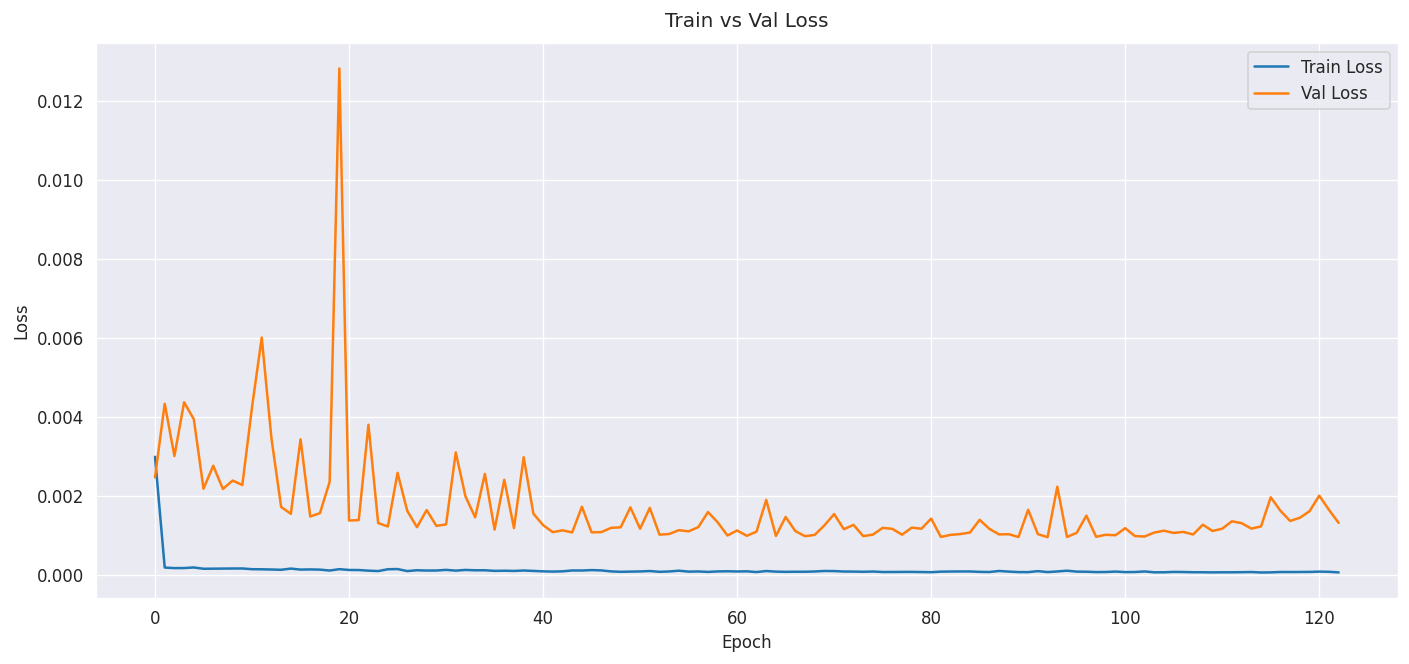

In [80]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
# Predict
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [82]:
# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")

LSTM RMSE: 5.33
LSTM MAE: 4.20


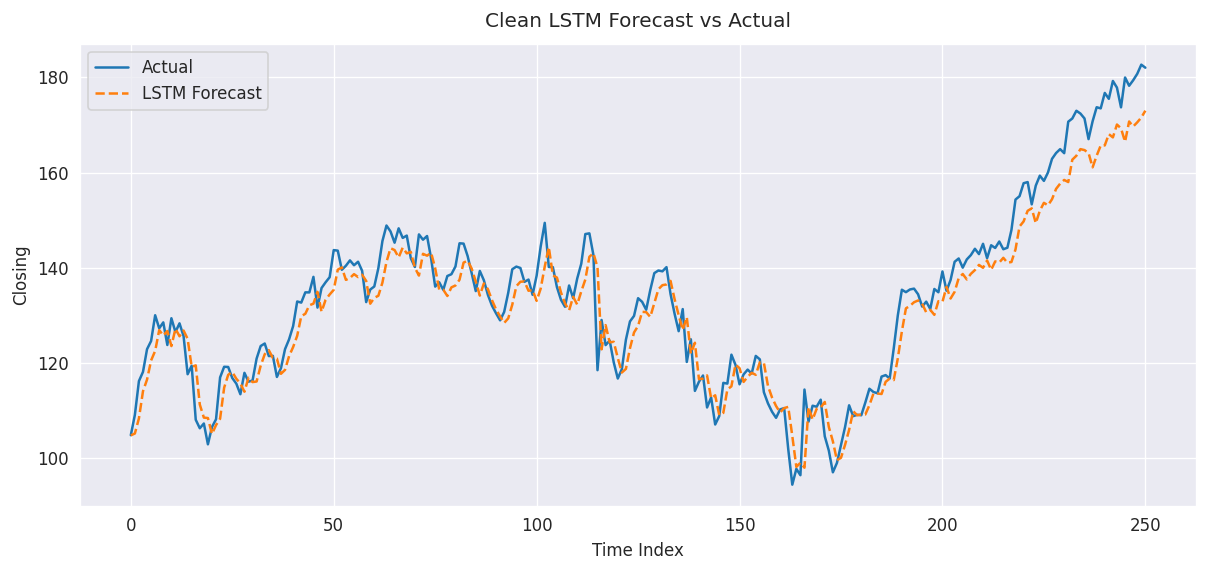

In [83]:
# 9. Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Forecast', linestyle='--')
plt.title("Clean LSTM Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Closing")
plt.legend()
plt.grid(True)
plt.show()

LSTM (Bi-directional)

In [84]:
# Sequence generation

def create_encoder_decoder_data(input_data, target_data, input_len=12, output_len=12):
    X, y = [], []
    total_len = input_len + output_len
    for i in range(len(input_data) - total_len + 1):
        X.append(input_data[i:i+input_len])
        y.append(target_data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

input_len = 12
output_len = 12

# Extend test with tail of train for full context
combined_data = np.vstack([train_scaled, test_scaled])
X_all, y_all = create_encoder_decoder_data(combined_data, combined_data, input_len, output_len)

In [85]:
# Train/test split for sequences

X_train, y_train = X_all[:len(train_scaled)-input_len-output_len+1], y_all[:len(train_scaled)-input_len-output_len+1]
X_test, y_test = X_all[len(train_scaled)-input_len-output_len+1:], y_all[len(train_scaled)-input_len-output_len+1:]

In [86]:
n_features = 1
encoder_inputs = Input(shape=(input_len, n_features))
encoder_lstm, state_h, state_c = LSTM(100, return_state=True)(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = RepeatVector(output_len)(encoder_lstm)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 100),     │     40,800 │ input_layer_1[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 12, 100)   │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 12, 100)   │     80,400 │ repeat_vector[0]… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 12, 1)     │        101 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
history = model.fit(X_train, y_train,
                    epochs=400,
                    batch_size=16,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0061 - val_loss: 0.0222
Epoch 2/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0391e-04 - val_loss: 0.0328
Epoch 3/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8733e-04 - val_loss: 0.0244
Epoch 4/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3096e-04 - val_loss: 0.0568
Epoch 5/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4066e-04 - val_loss: 0.0293
Epoch 6/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1109e-04 - val_loss: 0.0374
Epoch 7/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0870e-04 - val_loss: 0.0485
Epoch 8/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9436e-04 - val_loss: 0.0560
Epoch 9/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5208e-04 - val_loss: 0.0401
Epoch 10/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2630e-04 - val_loss: 0.0352
Epoch 11/400
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1262e-04 - val_loss: 0.0270
Epoch 12/400
56/56 ━━━

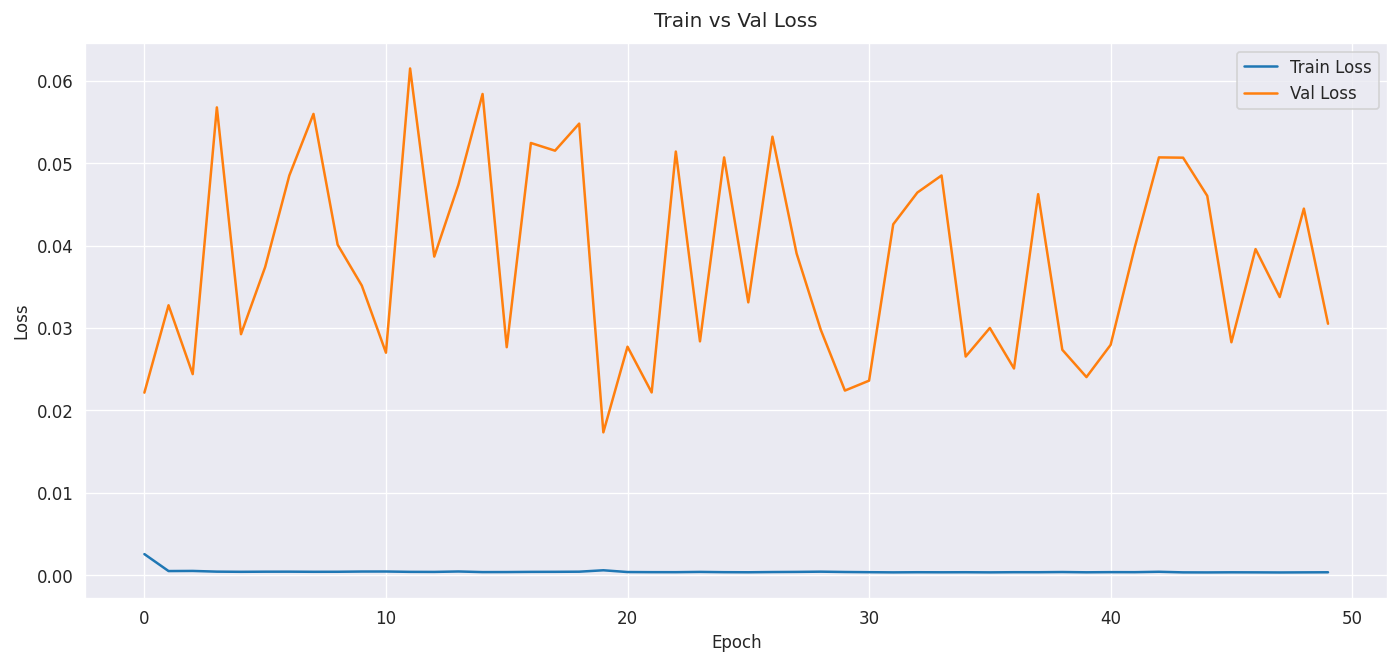

In [88]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [90]:
# Evaluate only the last predicted step of each sequence (optional)
rmse_ed = np.sqrt(mean_squared_error(y_test_inv[:, -1], y_pred_inv[:, -1]))
mae_ed = mean_absolute_error(y_test_inv[:, -1], y_pred_inv[:, -1])

print(f"Encoder-Decoder RMSE (last step): {rmse_ed:.2f}")
print(f"Encoder-Decoder MAE (last step): {mae_ed:.2f}")

Encoder-Decoder RMSE (last step): 35.44
Encoder-Decoder MAE (last step): 31.34


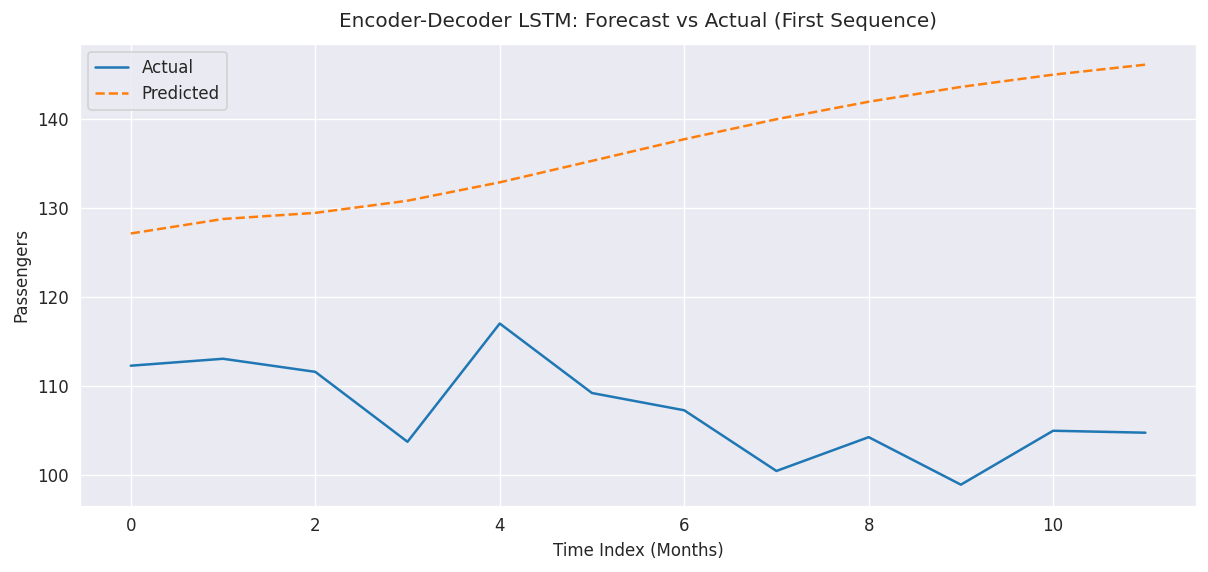

In [91]:
# 8. Plot one full prediction vs ground truth

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[0], label='Actual')
plt.plot(y_pred_inv[0], label='Predicted', linestyle='--')
plt.title("Encoder-Decoder LSTM: Forecast vs Actual (First Sequence)")
plt.xlabel("Time Index (Months)")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
from IPython.display import display

results = {
    "Model": [ "LSTM","Encoder-Decoder"],
    "RMSE": [rmse_lstm, rmse_ed],
    "MAE":  [ mae_lstm, mae_ed]
}

results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
display(results_df)

,RMSE,MAE
Model,,
LSTM,5.329101,4.19902
Encoder-Decoder,35.439581,31.34243
